In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert webdataset_creation_no_afni.ipynb --to python"
# call(command,shell=True)

[NbConvertApp] Converting notebook webdataset_creation_no_afni.ipynb to python
[NbConvertApp] Writing 18247 bytes to webdataset_creation_no_afni.py


0

In [ ]:
import os
import sys
import numpy as np
import boto3
import webdataset as wds
import nibabel as nib
import pickle as pkl
from einops import rearrange
from subprocess import call
import torchvision.transforms as transforms
from PIL import Image
import torch
import torchio as tio
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import json
from sklearn.preprocessing import StandardScaler

In [3]:
def reshape_to_2d(tensor):
    return rearrange(tensor, 'b h w c -> (b h) (c w)')

def reshape_to_original(tensor_2d, b=300, h=64, w=64, c=48):
    return rearrange(tensor_2d, '(b h) (c w) -> b h w c', b=b, h=h, w=w, c=c)

def header_to_dict(header):
    header=func_nii.header
    readable_header = {}
    # readable_header['Data Shape'] = header.get_data_shape()
    # readable_header['Voxel Size'] = header.get_zooms()
    # readable_header['Data Type'] = header.get_data_dtype()
    # readable_header['Dimension'] = header['dim'][0]
    for key, value in header.items():
        readable_header[key] = value
    return readable_header

def temporal_interp1d(fmri_data, change_TR):
    original_time_points = np.arange(fmri_data.shape[0])  # Time points: 0, 1, 2, ..., T-1
    new_time_points = np.arange(0, fmri_data.shape[0], change_TR)  # New time points: 0, 2, 4, ...

    reshaped_data = fmri_data.reshape(fmri_data.shape[0], -1)  # Reshape to (T, X*Y*Z)
    interpolate = interp1d(original_time_points, reshaped_data, kind='linear', axis=0, bounds_error=False, fill_value="extrapolate")
    resampled_fmri_data = interpolate(new_time_points).reshape((len(new_time_points),) + fmri_data.shape[1:])
    return resampled_fmri_data

def list_folders(bucket, prefix='', delimiter='/'):
    folder_names = []
    continuation_token = None
    while True:
        # Include the continuation token in the request if it exists
        kwargs = {'Bucket': bucket, 'Prefix': prefix, 'Delimiter': delimiter}
        if continuation_token:
            kwargs['ContinuationToken'] = continuation_token

        response = s3.list_objects_v2(**kwargs)
        folder_names.extend([x['Prefix'].split('/')[-2] for x in response.get('CommonPrefixes', [])])

        # Check if more items are available to retrieve
        if 'NextContinuationToken' in response:
            continuation_token = response['NextContinuationToken']
        else:
            break
    return folder_names

def torchio_slice(data,xslice=None,yslice=None,zslice=None):    
    if xslice is None: xslice = data.shape[1] // 2
    if yslice is None: yslice = data.shape[2] // 2
    if zslice is None: zslice = data.shape[3] // 2

    fig, axs = plt.subplots(1, 3, figsize=(5,5))

    # Plot the three different slices
    axs[0].imshow(data[0, xslice], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f'Slice [0, {xslice}]', fontsize=8)

    axs[1].imshow(data[0, :, yslice], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f'Slice [0, :, {yslice}]', fontsize=8)

    axs[2].imshow(data[0, :, :, zslice], cmap='gray')
    axs[2].axis('off')
    axs[2].set_title(f'Slice [0, :, :, {zslice}]', fontsize=8)
    
    plt.show()
    
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

In [4]:
outpath="/scratch/openneuro"
os.makedirs(os.path.dirname(outpath), exist_ok=True)
os.makedirs(f"{outpath}/tars", exist_ok=True)

## Below code assumes you are resuming your data creation from killed job ##

# copy metadata.json from s3 to /scratch
command = f"aws s3 cp s3://proj-fmri/openneuro/metadata.json {outpath}/tars/metadata.json --region us-west-2"
call(command,shell=True)

# read the metadata file
with open(f"{outpath}/tars/metadata.json", 'r') as file:
    metadata = json.load(file)
    
TR_count = metadata['TR_count']
subj_count = metadata['subj_count']
tar_count = metadata['tar_count'] + 1
dataset_count = metadata['dataset_count']
obj_key_list = metadata['obj_key_list']
dataset_list = metadata['datasets']

# delete existing tars
command = f"rm {outpath}/tars/*.tar"
call(command,shell=True)

download: s3://proj-fmri/openneuro/metadata.json to ../../../../../scratch/openneuro/tars/metadata.json


0

NUM_DATASETS: 1013 TRs_per_sample: 4 constant_TR: 2 max_samples_per_tar: 1280 max_TRs_per_tar: 5120
ds000001/sub-01/func/sub-01_task-balloonanalogrisktask_run-01_bold.nii.gz | TR_count: 0


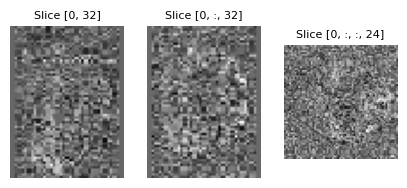

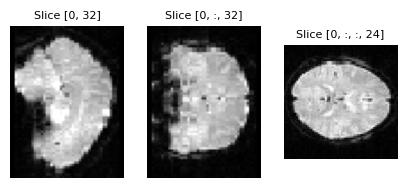

HIT MAX TRS PER TAR
upload: ../../../../../scratch/openneuro/tars/metadata.json to s3://proj-fmri/openneuro/metadata.json
upload: ../../../../../scratch/openneuro/tars/000000.tar to s3://proj-fmri/openneuro/000000.tar



KeyboardInterrupt



In [5]:
TRs_per_sample = 4
constant_TR = 2 # resample every func time series to have a "constant_TR"-second TR
max_samples_per_tar = 1280 # translates to around 1 Gb per tar
max_TRs_per_tar = max_samples_per_tar * TRs_per_sample

# Connect to S3
s3 = boto3.client('s3')

# Set the bucket name and folder name
bucket_name = 'openneuro.org'
folder_names = list_folders(bucket_name)
NUM_DATASETS = len(folder_names)

print(f"NUM_DATASETS: {NUM_DATASETS} TRs_per_sample: {TRs_per_sample} \
constant_TR: {constant_TR} max_samples_per_tar: {max_samples_per_tar} max_TRs_per_tar: {max_TRs_per_tar}")

# # If you want to start over webdataset creation from the beginning, uncomment these:
# tar_count = 0
# TR_count = 0
# subj_count = 0
# dataset_count = 0
# dataset_list = []
# obj_key_list = []

sample_idx = 0
current_dataset = None
current_subject = None
sink = wds.TarWriter(f"{outpath}/tars/{tar_count:06d}.tar")

for folder_name in folder_names:
    # List all objects in the folder
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)

    for obj in response.get('Contents', []):
        obj_key = obj['Key']

#         if '_T1w.nii.gz' in obj_key: # Anatomical
#             # Store subject number to verify anat/func match
#             anat_subj = obj_key.split('/')[1]
            
#             # Download the object to tmp location
#             filename = os.path.join('openneuro', obj_key)
#             os.makedirs(os.path.dirname(filename), exist_ok=True)
#             s3.download_file(bucket_name, obj_key, filename)

#             # store the header of anat
#             anat_header = nib.load(filename).header
            
        if '_bold.nii.gz' in obj_key:
            func_subj = obj_key.split('/')[1]
            
            # Verify func/anat subject number match
            # if anat_subj != func_subj:
            #     print('Incompatible subject number found. Skipping...')
            #     continue
                
            # if metadata file shows you already processed this file, skip it
            if np.isin(obj_key, obj_key_list):
                continue
            
            filename = os.path.join(f'{os.getcwd()}/openneuro', obj_key)
            
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            if not os.path.exists(filename):
                s3.download_file(bucket_name, obj_key, filename)

            func_nii = nib.load(filename)

            tio_transforms = tio.Compose(
                (
                    tio.ToCanonical(), # make sure orientation of brains are consistent (RAS+ orientation)
                    tio.RescaleIntensity(out_min_max=(0, 1),percentiles=(0.5, 99.8)),
                    tio.Resample(3, image_interpolation='nearest'), # rescale voxels to #mm isotropic
                    tio.CropOrPad((64, 64, 48)),
                )
            )

            # tio_image = tio.ScalarImage(filename, dtype=np.float32)
            try:
                tio_image = tio.ScalarImage(tensor=np.moveaxis(func_nii.get_fdata(),-1,0).astype(np.float32), 
                                        affine=func_nii.affine, 
                                        dtype=np.float32)
                out = tio_transforms(tio_image)['data']            
            except:
                continue # this can happen if the func is actually 3d and not 4d

            # resample to correct Repetition Time if necessary
            orig_TR = func_nii.header.get_zooms()[3]
            if orig_TR <= 0: # skip if somehow the TR is zero or negative (this does happen!)
                continue
            change_TR = constant_TR / orig_TR
            if orig_TR != constant_TR:
                out = temporal_interp1d(out, change_TR)
                
            # zscore across the run
            out_shape = out.shape
            out = out.reshape(len(out),-1)
            scalar = StandardScaler(with_mean=True, with_std=True).fit(out)
            mean = scalar.mean_
            sd = scalar.scale_
            out = (out - mean) / sd
            mean = mean.reshape([out_shape[1],out_shape[2],out_shape[3]])
            sd = sd.reshape([out_shape[1],out_shape[2],out_shape[3]])
            meansd = np.array([mean,sd])
            out = out.reshape(out_shape)
            
            # create 16-bit png of mean and sd volumes
            meansd_images = reshape_to_2d(meansd)
            meansd_images = torch.Tensor(meansd_images)
            min_meansd, max_meansd = meansd_images.min(), meansd_images.max() 
            minmax_meansd_images = (meansd_images - min_meansd) / (max_meansd - min_meansd) # first you need to rescale to 0 to 1
            rescaled_images = (minmax_meansd_images * 65535).to(torch.int16) # then multiply by constant prior to numpy uint16
            rescaled_images_numpy = rescaled_images.numpy().astype(np.uint16)
            meansd_PIL_image = Image.fromarray(rescaled_images_numpy, mode='I;16')

            # create samples of 4 TRs (1 TR = 2 seconds)
            for batch in range(0,len(out),TRs_per_sample):
                if len(out[batch:batch+TRs_per_sample])<TRs_per_sample: continue
                images = reshape_to_2d(out[batch:batch+TRs_per_sample])
                images = torch.Tensor(images)

                # convert tensor to something compatible with 16-bit png
                min_, max_ = images.min(), images.max()
                minmax_images = (images - min_) / (max_ - min_) # first you need to rescale to 0 to 1
                rescaled_images = (minmax_images * 65535).to(torch.int16) # then multiply by constant prior to numpy uint16
                rescaled_images_numpy = rescaled_images.numpy().astype(np.uint16)
                PIL_image = Image.fromarray(rescaled_images_numpy, mode='I;16')
                
                if current_dataset != obj['Key'].split('/')[0]:
                    print(obj_key, "| TR_count:", TR_count)
                    dataset_list.append(obj['Key'].split('/')[0])
                    dataset_count += 1
                    if is_interactive(): # dont want to plot unless you are in interactive notebook
                        torchio_slice(out) # plot normalized slices
                        torchio_slice((out * sd) + mean) # plot unnormalized slices
                
                if current_subject != obj['Key'].split('/')[1]: 
                    subj_count += 1
                current_dataset = obj['Key'].split('/')[0]  
                current_subject = obj['Key'].split('/')[1]  

                sink.write({
                    "__key__": "%06d" % sample_idx,
                    "dataset.txt": obj_key,
                    "header.npy": np.array(header_to_dict(func_nii.header)),
                    "minmax.npy": np.array([min_, max_, min_meansd, max_meansd]),
                    "meansd.png": meansd_PIL_image,
                    "func.png": PIL_image, # 27M for 8-bit png vs 48M for 16-bit png vs 144M for numpy
                })
                # "func.npy": out[batch:batch+TRs_per_sample].numpy(),
                TR_count += TRs_per_sample
                sample_idx += 1

                if sample_idx >= max_samples_per_tar:
                    print("HIT MAX TRS PER TAR")
                    sink.close()
                    sample_idx = 0
                    
                    # make metadata file and save progress to aws s3
                    data = {
                        "TR_count": TR_count,
                        "subj_count": subj_count,
                        "tar_count": tar_count,
                        "dataset_count": dataset_count,
                        "datasets": dataset_list,
                        "obj_key_list": obj_key_list,
                    }
                    with open(f"{outpath}/tars/metadata.json", "w") as file:
                        json.dump(data, file)

                    # send to aws s3
                    command = f"aws s3 sync {outpath}/tars s3://proj-fmri/openneuro --region us-west-2"
                    call(command,shell=True)
                    
                    # delete tars
                    command = f"rm {outpath}/tars/*.tar"
                    call(command,shell=True)
                    
                    tar_count += 1
                    sink = wds.TarWriter(f"{outpath}/tars/{tar_count:06d}.tar")
                    
            obj_key_list.append(obj['Key'])

            # delete the nifti now that youve saved it to numpy
            call(f"rm {filename}",shell=True) 

try:
    sink.close()
except:
    pass

print("TR_count",TR_count)
print("subj_count",subj_count)
print("dataset_count",dataset_count)
print("tar_count", tar_count)

In [ ]:
data = {
    "TR_count": TR_count,
    "subj_count": subj_count,
    "tar_count": tar_count,
    "dataset_count": dataset_count,
    "datasets": dataset_list,
    "obj_key_list": obj_key_list,
}
print(data)

with open(f"{outpath}/tars/metadata.json", "w") as file:
    json.dump(data, file)
    
# send to aws s3
command = f"aws s3 sync {outpath}/tars s3://proj-fmri/openneuro --region us-west-2"
call(command,shell=True)

# delete tars
command = f"rm {outpath}/tars/*.tar"
call(command,shell=True)

# old code

In [ ]:
# plt.hist(out[0].ravel(), bins=100, histtype='step', color='black')
# plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
# plt.xlabel('Pixel intensity')

# def plot_img_and_hist(image, axes, bins=256):
#     """Plot an image along with its histogram and cumulative histogram."""
#     # image = img_as_float(image)
#     ax_img, ax_hist = axes
#     ax_cdf = ax_hist.twinx()

#     # Display image
#     ax_img.imshow(image, cmap=plt.cm.gray)
#     ax_img.set_axis_off()

#     # Display histogram
#     ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
#     ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
#     ax_hist.set_xlabel('Pixel intensity')
#     ax_hist.set_xlim(0, 1)
#     ax_hist.set_yticks([])

#     # Display cumulative distribution
#     img_cdf, bins = exposure.cumulative_distribution(image, bins)
#     ax_cdf.plot(bins, img_cdf, 'r')
#     ax_cdf.set_yticks([])

#     return ax_img, ax_hist, ax_cdf

In [ ]:
# OLD CODE #
#             # AFNI #
#             # Step 1: Reorient the functional image to match the anatomical image's orientation
#             reoriented_func_img = reorient_to_match(anat_nii, func_nii)

#             # Step 2: Rigid Body Transformation with SimpleITK
#             registered_func_img_sitk = align_images(anat_nii_sitk, reoriented_func_img)

#             # Step 3: Convert SimpleITK image to Nibabel
#             sitk_array = np.flip(sitk.GetArrayFromImage(registered_func_img_sitk), axis=(0,1,2))
#             sitk_affine = registered_func_img_sitk.GetDirection()
#             resampled_func_img = nib.Nifti1Image(sitk_array.astype(np.float32), 
#                                                  anat_nii.affine)

#             # Verify visually if result looks ok
            
#             plotting.plot_img(resampled_func_img, display_mode='ortho', cut_coords=(30,30,30))
#             err     


####
# def reorient_to_match(target_img, img_to_reorient):    
#     # Get the target orientation
#     target_ornt = nib.orientations.io_orientation(target_img.affine)

#     # Get the orientation of the image to reorient
#     img_ornt = nib.orientations.io_orientation(img_to_reorient.affine)

#     # Get the transformation between the orientations
#     ornt_trans = nib.orientations.ornt_transform(img_ornt, target_ornt)

#     # Check if the orientations are the same
#     if not np.array_equal(target_ornt, img_ornt):
#         # Get the transformation between the orientations
#         ornt_trans = nib.orientations.ornt_transform(img_ornt, target_ornt)

#         # Apply the transformation
#         reoriented_img = img_to_reorient.as_reoriented(ornt_trans)
#         return reoriented_img
#     else:
#         return img_to_reorient

# def align_images(fixed_image, moving_nii, moving_image_volume=0):
#     # Load the moving image and extract a single volume if it's 4D
#     if len(moving_nii.shape) == 4:
#         moving_image_data = moving_nii.get_fdata()[:,:,:,moving_image_volume]
#     else:
#         moving_image_data = moving_nii.get_fdata()

#     # Convert the numpy array back to a SimpleITK Image
#     moving_image = sitk.GetImageFromArray(moving_image_data.astype(np.float32))
    
#     # Extract the spacing from the Nibabel header and convert to tuple
#     nib_spacing = moving_nii.header.get_zooms()[:3]
#     moving_image.SetSpacing(tuple(float(sz) for sz in nib_spacing))

#     # Initialize the registration method
#     registration_method = sitk.ImageRegistrationMethod()

#     # Set the registration parameters
#     registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#     registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
#     registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
#     registration_method.SetOptimizerScalesFromPhysicalShift()

#     # Initialize the transform with CenteredTransformInitializer
#     initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
#                                                           moving_image, 
#                                                           sitk.Euler3DTransform(), 
#                                                           sitk.CenteredTransformInitializerFilter.GEOMETRY)

#     # Set the initial transform for registration
#     registration_method.SetInitialTransform(initial_transform)

#     # Perform the registration
#     final_transform = registration_method.Execute(fixed_image, moving_image)

#     # Apply the transform to the moving image
#     resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
#     return resampled